In [6]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_last')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

## Function to preprocess the image

In [19]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
#     img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('/')[-2])

# Test a image randomly

In [20]:
def loadTrainImages(path='data/Train'):
    classes = [ g for g in os.listdir(path) if os.path.isdir(path + '/' + g)]

    images = []
    labels = []

    for classid in classes:
        image_class_path = os.path.join(path, classid)

        image_files = sorted([os.path.join(image_class_path, file)
                 for file in os.listdir(image_class_path) if file.endswith('.png')])
        
        images.extend(image_files)
        labels.extend([ int(classid) ] * len(image_files))

    return np.array(images), np.array(labels)

def display(a, b, title1 = "Original", title2 = "HSV"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [21]:
train_image, y_train = loadTrainImages()

train_image.shape, y_train.shape

((39209,), (39209,))

In [23]:
random_image_file = train_image[300]
random_image = cv2.imread(random_image_file)

random_image_hsv = preprocess_img(random_image)

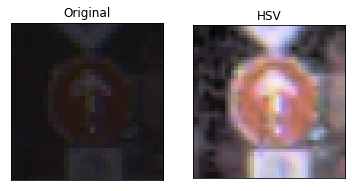

((30, 29, 3), (48, 48, 3))

In [24]:
display(random_image, random_image_hsv)
random_image.shape, random_image_hsv.shape

## Preprocess all training images into a numpy array

In [141]:
try:
    with  h5py.File('X1.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'GTSRB/Final_Training/Images/'
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

<ipython-input-141-ee66c917395e>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with  h5py.File('X1.h5') as hf:


Error in reading X.h5. Processing all images...
Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209


# Define Keras model

In [142]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

# Start Training

In [143]:
batch_size = 32
nb_epoch = 10

history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Epoch 1/10
981/981 [==============================] - 424s 432ms/step - loss: 1.7546 - accuracy: 0.5126 - val_loss: 0.2318 - val_accuracy: 0.9283
Epoch 2/10
981/981 [==============================] - 465s 474ms/step - loss: 0.2475 - accuracy: 0.9248 - val_loss: 0.0877 - val_accuracy: 0.9736
Epoch 3/10
981/981 [==============================] - 349s 355ms/step - loss: 0.1375 - accuracy: 0.9579 - val_loss: 0.0562 - val_accuracy: 0.9818
Epoch 4/10
981/981 [==============================] - 281s 286ms/step - loss: 0.1021 - accuracy: 0.9696 - val_loss: 0.0606 - val_accuracy: 0.9815
Epoch 5/10
981/981 [==============================] - 475s 484ms/step - loss: 0.0771 - accuracy: 0.9766 - val_loss: 0.0320 - val_accuracy: 0.9903
Epoch 6/10
981/981 [==============================] - 335s 342ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.0479 - val_accuracy: 0.9847
Epoch 7/10
981/981 [==============================] - 281s 286ms/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0335 -

# Load Test data

In [144]:
import pandas as pd
test = pd.read_csv('GTSRB/GT-final_test.csv',sep=';')

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

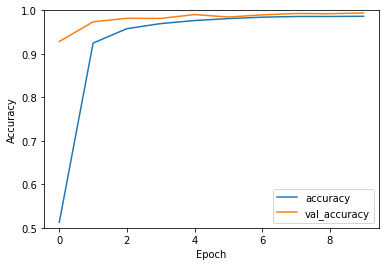

In [145]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [10]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test accuracy = 0.960332541567696
